#**Embedded_AI_Project_2**

Outline of this notebook


*   Prerequisite Installation and Importing libraries
*   Loading the Pretrained Model
*   Pruning the fine tuned model
*   Quantization the model
*   Model Testing
*   Conclusion







## **Prerequisite Installation and Importing libraries**

On this step we install the required libraries and import them for next steps

**tensorflow-model-optimization** library will be used for model pruing and quantization.

Other required libraries are keras and tensorflow already on google colab for machine learning model processing

In [2]:
!pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 3.8 MB/s eta 0:00:00


In [3]:
import tempfile
import os
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
tf.random.set_seed(
    seed=81
)

## **Loading the Pretrained Model**

On this step we load the pretrained model for prunning and quantization from github repository

### Download the pretrained model from github

In [4]:
file_url = 'https://github.com/raisul-kibria/EmbAI_2024/blob/master/saved_model/Full_Precision_MNIST_TF.h5'

# destination_filename = 'Full_Precision_MNIST_TF.h5'
_, destination_filename = tempfile.mkstemp('.h5')

!wget -O {destination_filename} {file_url}


--2024-05-26 23:05:46--  https://github.com/raisul-kibria/EmbAI_2024/blob/master/saved_model/Full_Precision_MNIST_TF.h5
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/tmp/tmpd2h514tx.h5’

/tmp/tmpd2h514tx.h5     [  <=>               ] 259.23K  1.15MB/s    in 0.2s    

2024-05-26 23:05:47 (1.15 MB/s) - ‘/tmp/tmpd2h514tx.h5’ saved [265455]



In [5]:
!ls
!pwd

sample_data
/content


## **Pruning the fine tuned model**

On this step we fine tune the model by applying the pruning API and see the accuracy

### **Preprocessing**

In [6]:
batch_size = 128
n_epochs = 4

In [7]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [8]:
def extract_labels(dataset):
    labels = []
    for _, label in dataset:
        labels.append(label.numpy())
    return np.array(labels)

# Extract labels for train and test datasets
train_labels = extract_labels(ds_train)
test_labels = extract_labels(ds_test)

# Print the shape of the labels arrays
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train labels shape: (54000,)
Test labels shape: (10000,)


Input image shape: (28, 28, 1)
Image type: <dtype: 'uint8'>
Label shape: ()
Label type: <dtype: 'int64'>


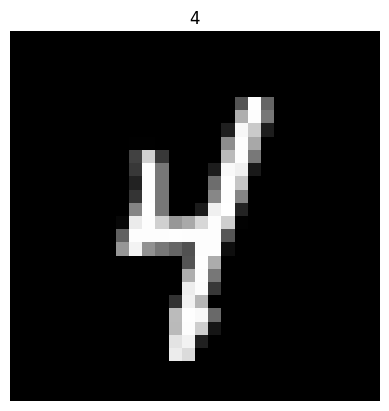

In [9]:
ds = ds_train.take(1)  # Only take a single example
for example in ds:  # example is `('image': tf.Tensor, 'label': tf.Tensor)`
  image = example[0]
  label = example[1]
  print(f"Input image shape: {image.shape}\nImage type: {image.dtype}")
  print(f"Label shape: {label.shape}\nLabel type: {label.dtype}")
  plt.imshow(image, cmap='gray')
  plt.title(label.numpy())
  plt.axis("off")
  plt.show()

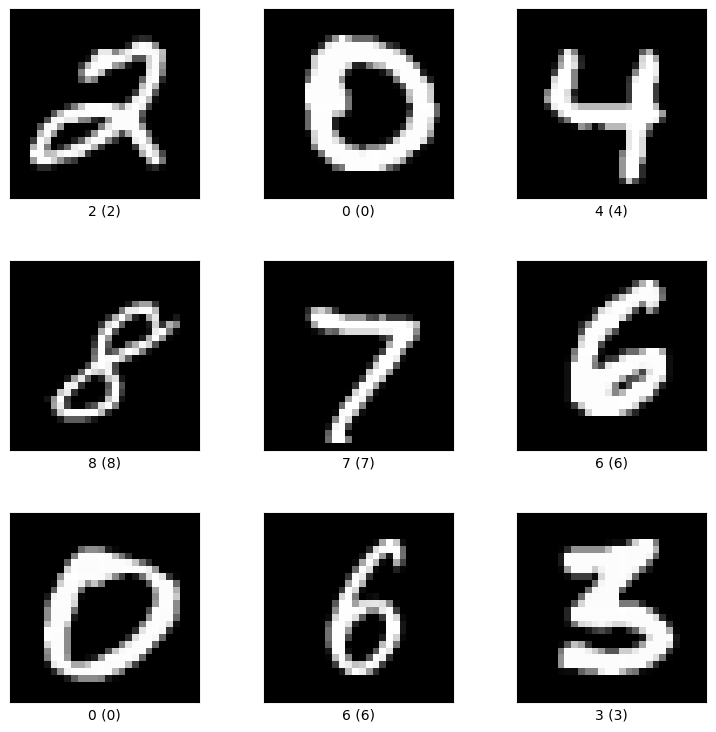

In [10]:
fig = tfds.show_examples(ds_test, ds_info)

In [11]:
def normalize_img(image:tf.uint8, label:tf.int64):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def normalize_splits(ds, split_name: str, batch_size: int):
  """Applies preprocessing to train, val and test sets"""
  ds = ds.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE
  )
  ds = ds.cache() # Caching makes it faster for consecutive runs
  if split_name != 'test':
    # Shuffling is not done for the test set
    ds = ds.shuffle(ds_info.splits[split_name].num_examples)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
ds_train = normalize_splits(ds_train, split_name='train[:90%]', batch_size=batch_size)
ds_val = normalize_splits(ds_val, split_name='train[90%:]', batch_size=batch_size)
ds_test = normalize_splits(ds_test, split_name='test', batch_size=batch_size)

### **Training Neural Network**

In [13]:
# Define the model architecture (LeNet-5).

model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=6, kernel_size=(5, 5), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(120),
  keras.layers.Dense(84),
  keras.layers.Dense(10, activation='softmax')
])

# As truth labels are integer encoded, we use sparse categorical cross-entropy as loss fn
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # the ouputs are expected as probabilities
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 120)               9

In [14]:
model.fit(
  ds_train,
  epochs=n_epochs,
  validation_data=ds_val,
)

Epoch 1/4
422/422 [==============================] - 44s 96ms/step - loss: 0.2563 - accuracy: 0.9232 - val_loss: 0.0857 - val_accuracy: 0.9750
Epoch 2/4
422/422 [==============================] - 36s 84ms/step - loss: 0.0755 - accuracy: 0.9766 - val_loss: 0.0679 - val_accuracy: 0.9808
Epoch 3/4
422/422 [==============================] - 37s 88ms/step - loss: 0.0580 - accuracy: 0.9818 - val_loss: 0.0628 - val_accuracy: 0.9820
Epoch 4/4
422/422 [==============================] - 37s 88ms/step - loss: 0.0466 - accuracy: 0.9851 - val_loss: 0.0571 - val_accuracy: 0.9833


In [15]:
_, baseline_accuracy = model.evaluate(
    ds_test, verbose=0)

print('Baseline test accuracy:', baseline_accuracy)

Baseline test accuracy: 0.9843000173568726


In [16]:
import tempfile
import os

In [17]:
# Saving the model in .h5 format

keras_file = './Full_Precision_MNIST_TF.h5'
if os.path.exists(keras_file):
        # If the file exists, delete it
        os.remove(keras_file)

with open(keras_file, 'w') as file:
        print('empty file created ')

keras.models.save_model(model, keras_file, include_optimizer=False)


empty file created 


<ipython-input-17-fbf02abb530e>:11: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, keras_file, include_optimizer=False)


### **Prunning the model**

In [18]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow_model_optimization.python.core.keras.compat import keras

%load_ext tensorboard


In [19]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = len(ds_train) * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 6)         308       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 6)         1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 14, 14, 16)        4818      
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 7, 7, 16)          1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                                                    

In [20]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(ds_train,
                  batch_size=batch_size, epochs=epochs, #validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


422/422 [==============================] - 40s 85ms/step - loss: 0.0433 - accuracy: 0.9869
Epoch 2/2
422/422 [==============================] - 36s 85ms/step - loss: 0.0348 - accuracy: 0.9888


In [21]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   ds_test, verbose=0)

print('Baseline test accuracy:', baseline_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9843000173568726
Pruned test accuracy: 0.9836000204086304


### **3x smaller models from pruning**

In [22]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

<ipython-input-22-395ce8c5b5c5>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model to: /tmp/tmp5qzojj4c.h5


In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Saved pruned TFLite model to: /tmp/tmpjhje2z3x.tflite


In [24]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 401917.00 bytes
Size of gzipped pruned Keras model: 402468.00 bytes
Size of gzipped pruned TFlite model: 400547.00 bytes


### **Statistics**

On this step we plot the graphs for comparison

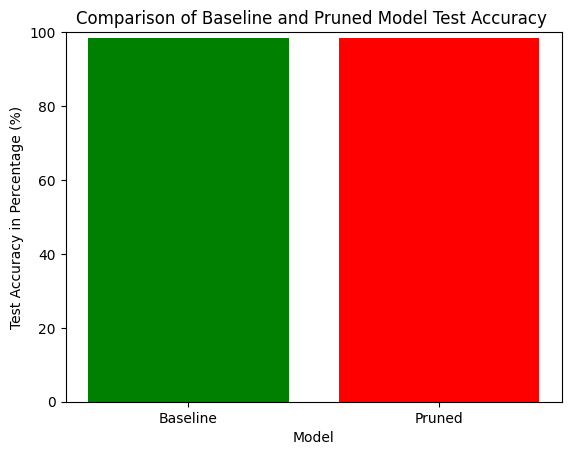

In [25]:
import matplotlib.pyplot as plt

categories = ['Baseline', 'Pruned']
accuracy_values = [baseline_accuracy * 100, model_for_pruning_accuracy * 100]

# plt.figure(figsize=(8, 6))
plt.bar(categories, accuracy_values, color=['green', 'red'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy in Percentage (%)')
plt.title(f'Comparison of Baseline and Pruned Model Test Accuracy ')
plt.ylim(0, 100)
plt.show()


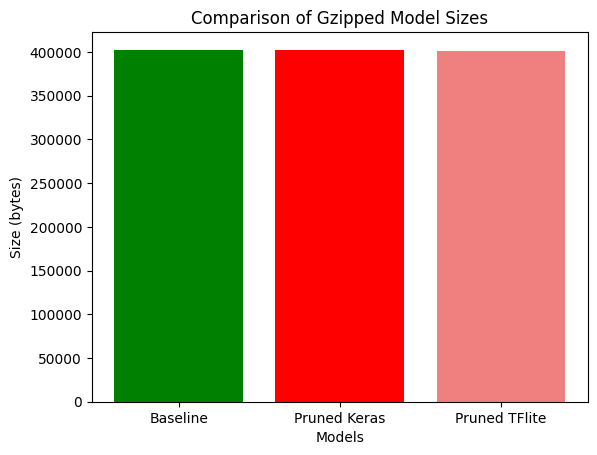

In [26]:
import matplotlib.pyplot as plt


baseline_size = get_gzipped_model_size(keras_file)
pruned_keras_size = get_gzipped_model_size(pruned_keras_file)
pruned_tflite_size = get_gzipped_model_size(pruned_tflite_file)

models = ['Baseline', 'Pruned Keras', 'Pruned TFlite']

sizes = [baseline_size, pruned_keras_size, pruned_tflite_size]


# plt.figure(figsize=(10, 6))
plt.bar(models, sizes, color=['Green', 'Red', 'lightcoral'])
plt.xlabel('Models')
plt.ylabel('Size (bytes)')
plt.title('Comparison of Gzipped Model Sizes')
plt.show()


##**Quantization of the model**

On this step we quantize the model.

### **10x smaller model from combining pruning and quantization**

In [27]:
def representative_dataset():
  for data in ds_test.take(100):
    yield [tf.dtypes.cast(data[0], tf.float32)]

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved quantized and pruned TFLite model to: /tmp/tmpwly_xaig.tflite
Size of gzipped baseline Keras model: 401917.00 bytes
Size of gzipped pruned and quantized TFlite model: 95559.00 bytes


### **persistence of accuracy from TF to TFLite**

In [29]:
ds_test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []

    for test_images, labels in ds_test:
        # Flatten the batch dimension for test_labels
        test_labels.extend(labels.numpy())
        for i, test_image in enumerate(test_images):
            if i % 1000 == 0:
                print(f'Evaluated on {len(prediction_digits)} results so far.')

            # Pre-processing: add batch dimension and convert to float32 to match with
            # the model's input data format.
            test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
            interpreter.set_tensor(input_index, test_image)

            # Run inference.
            interpreter.invoke()

            # Post-processing: remove batch dimension and find the digit with highest
            # probability.
            output = interpreter.get_tensor(output_index)
            digit = np.argmax(output[0])
            prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    test_labels = np.array(test_labels)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [35]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

quantized_and_pruned_tflite_model_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', quantized_and_pruned_tflite_model_accuracy)
print('Pruned TF test accuracy:', model_for_pruning_accuracy)


Evaluated on 0 results so far.
Evaluated on 128 results so far.
Evaluated on 256 results so far.
Evaluated on 384 results so far.
Evaluated on 512 results so far.
Evaluated on 640 results so far.
Evaluated on 768 results so far.
Evaluated on 896 results so far.
Evaluated on 1024 results so far.
Evaluated on 1152 results so far.
Evaluated on 1280 results so far.
Evaluated on 1408 results so far.
Evaluated on 1536 results so far.
Evaluated on 1664 results so far.
Evaluated on 1792 results so far.
Evaluated on 1920 results so far.
Evaluated on 2048 results so far.
Evaluated on 2176 results so far.
Evaluated on 2304 results so far.
Evaluated on 2432 results so far.
Evaluated on 2560 results so far.
Evaluated on 2688 results so far.
Evaluated on 2816 results so far.
Evaluated on 2944 results so far.
Evaluated on 3072 results so far.
Evaluated on 3200 results so far.
Evaluated on 3328 results so far.
Evaluated on 3456 results so far.
Evaluated on 3584 results so far.
Evaluated on 3712 result

### **Statistics**

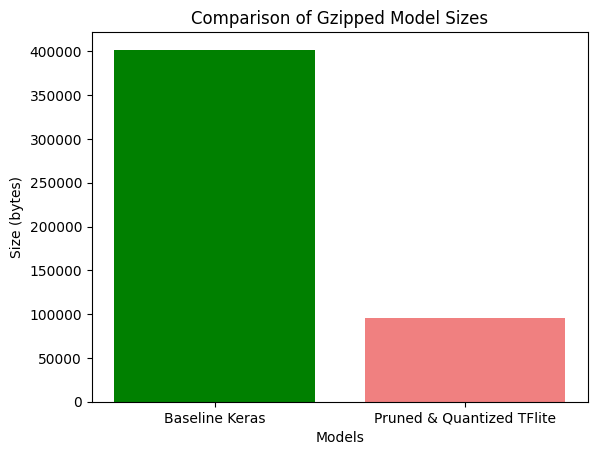

In [34]:
import matplotlib.pyplot as plt

baseline_size = get_gzipped_model_size(keras_file)
quantized_pruned_tflite_size = get_gzipped_model_size(quantized_and_pruned_tflite_file)

models = ['Baseline Keras', 'Pruned & Quantized TFlite']

sizes = [baseline_size, quantized_pruned_tflite_size]

# Plotting the bar chart
# plt.figure(figsize=(10, 6))
plt.bar(models, sizes, color=['Green', 'lightcoral'])
plt.xlabel('Models')
plt.ylabel('Size (bytes)')
plt.title('Comparison of Gzipped Model Sizes')
plt.show()


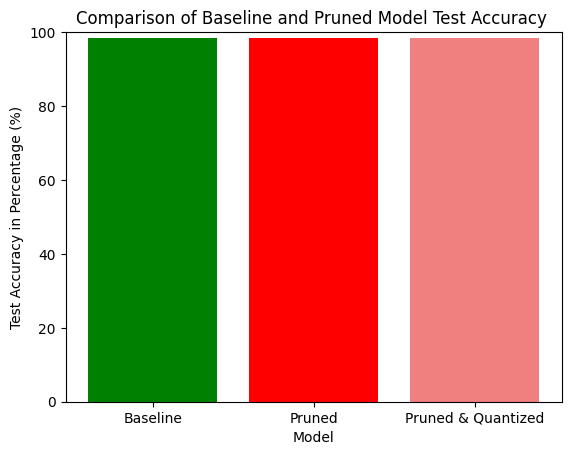

In [36]:
import matplotlib.pyplot as plt

categories = ['Baseline', 'Pruned' , 'Pruned & Quantized']
accuracy_values = [baseline_accuracy * 100, model_for_pruning_accuracy * 100, quantized_and_pruned_tflite_model_accuracy * 100]

# plt.figure(figsize=(8, 6))
plt.bar(categories, accuracy_values, color=['green', 'red', 'lightcoral'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy in Percentage (%)')
plt.title(f'Comparison of Baseline and Pruned Model Test Accuracy ')
plt.ylim(0, 100)
plt.show()

## **Model Testing**

## **Exporting Model for Embdeded Device**

In [37]:
quantized_and_pruned_tflite_file

'/tmp/tmpwly_xaig.tflite'

In [38]:
destination_file = "./quantized_and_pruned_tflite_file.tflite"

if os.path.exists(destination_file):
        os.remove(destination_file)
        print("Previous destination file deleted:", destination_file)

with open(quantized_and_pruned_tflite_file, 'rb') as source:
      with open(destination_file, 'wb') as destination:
            destination.write(source.read())
print("File copied successfully to:", destination_file)

File copied successfully to: ./quantized_and_pruned_tflite_file.tflite


In [39]:
!echo "const unsigned char model[] = {" > ./model.h
!cat quantized_and_pruned_tflite_file.tflite | xxd -i      >> ./model.h
!echo "};"                              >> ./model.h

import os

model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 698,496 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


## **Conclusion**